## Dealing with unlabeled data (Semi-supervised learning)
### Case Study (MNIST-Fashion dataset)
### by Mehmet Solmaz, August 2018

#### Problem definition: Given a huge dataset, only a small part of which is assigned a known label (out of a set of N), and also given a human labeler that comes at a cost. How to build a classifier while minimizing the cost?
#### In other words, formally given: <br> (1) A small dataset with (x,y) pairs,<br> (2) Large dataset with (x,) pairs. <br> Our goal is to find a better classifier than from just the labeled data alone. 

Firstly, this problem is between Supervised and Unsupervised Learning algorithms (Semi-supervised). We only have certain amount of labeled data. In the case of Big Data, the percentage of labeled data could be less than 1%. Even if we get a human labeler at a certain cost, we might not be able to label each data point.<br>
Here are some approaches to be considered:

1- First approach could be using the small subset of data for training, and use it to label the rest of the unlabeled data. Then use it to retrain the whole dataset and build a model <br>
2- Second approach could be using Clustering on the dataset. We can decide the class by looking at the majority of labeled data points in that cluster. 

In this notebook, I have tried to simulate the first approach on an MNIST-Fashion image dataset. Image dataset was chosen because they require a human labeler for classification purposes.<br>

MNIST-Fashion dataset comes with all the data labeled. To mimick a semi-supervised learning problem, I have deliberately removed certain percentages (99%, 95%, 90%, and 80%) of data and built classifiers with minimal data. That is, I have built classifiers with 1%, 5%, 10%, 20% of the initial data while randomly removing the rest. At each time, I have predicted the labels of unused data using the ML model, and compared with the Ground Truth (already labeled data). I have also built a classifier using 100% of the data and obtained performance metrics. 

For each classifier, I recorded the f1-scores, which were later used in Curve-Fitting to obtain a trend between Used Data Percentage and f1-score. The fitted function (logarithmic) reveals that there is a inflexion point where the increase in f1-score slows down. In this experiment, the inflexion point is around 15%. This point can be used as the minimum performance point to be reached via the help of human labelers. 

To sum up, to minimize the cost associated with human labelers, they should be used to add labels to the dataset only in the large performance increment regime. If the performance of the classifier starts slowing down at consecutive increments, this is the point to stop human labeling because there may not be any substantial improvement in classification performance.

__Footnote__: Another dataset may not show the same behavior as MNIST. From what I have gathered from the literature, datasets with high quality labels are more suitable for this approach. MNIST is one of them. 

In [1]:
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
# import the necessary packages
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import curve_fit

Using TensorFlow backend.


In [2]:
from keras.datasets import fashion_mnist

In [3]:
(x_train, y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [4]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape, "y_test shape:", Y_test.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


Example image from class 8


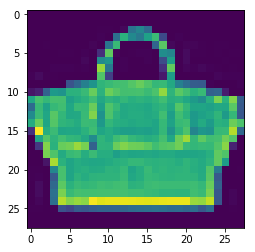

In [5]:
# Show one of the images from the training dataset
index = 233
plt.imshow(x_train[index,:,:])
print ("Example image from class " + str(np.squeeze(y_train[index])))

In [6]:
x_train = x_train.reshape([-1, 28, 28, 1])
X_test = X_test.reshape([-1, 28, 28, 1])

In [7]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape, "y_test shape:", Y_test.shape)

x_train shape: (60000, 28, 28, 1) y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1) y_test shape: (10000,)


In [8]:
# Split the training data into Train, and Validation 
# Use test for prediction
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [9]:
X_train = np.divide(X_train,255)
X_test = np.divide(X_test,255)
X_val = np.divide(X_val,255)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 48000
number of test examples = 10000
number of validation examples = 12000
X_train shape: (48000, 28, 28, 1)
Y_train shape: (48000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)
X_val shape: (12000, 28, 28, 1)
Y_val shape: (12000, 10)


In [10]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # 10 classes

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
__________

In [12]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-03, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [13]:
my_model = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20,shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 110s 2ms/step - loss: 0.7564 - acc: 0.7177 - val_loss: 0.4531 - val_acc: 0.8425
Epoch 2/20
48000/48000 [==============================] - 109s 2ms/step - loss: 0.4862 - acc: 0.8215 - val_loss: 0.3646 - val_acc: 0.8658
Epoch 3/20
48000/48000 [==============================] - 106s 2ms/step - loss: 0.4170 - acc: 0.8482 - val_loss: 0.3250 - val_acc: 0.8809
Epoch 4/20
48000/48000 [==============================] - 90s 2ms/step - loss: 0.3818 - acc: 0.8596 - val_loss: 0.3172 - val_acc: 0.8839
Epoch 5/20
48000/48000 [==============================] - 90s 2ms/step - loss: 0.3599 - acc: 0.8679 - val_loss: 0.3044 - val_acc: 0.8883
Epoch 6/20
48000/48000 [==============================] - 91s 2ms/step - loss: 0.3460 - acc: 0.8723 - val_loss: 0.2865 - val_acc: 0.8949
Epoch 7/20
48000/48000 [==============================] - 92s 2ms/step - loss: 0.3316 - acc: 0.8780 - val_loss: 0.2841 - val_

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy Acquired:', test_accuracy)

Test accuracy Acquired: 0.9032


In [15]:
print(my_model.history.keys())

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


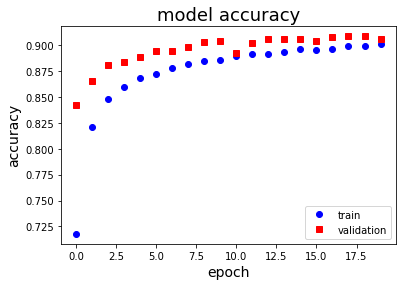

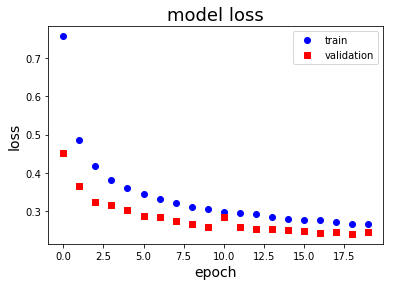

In [16]:
# summarize history for accuracy
plt.plot(my_model.history['acc'], 'bo')
plt.plot(my_model.history['val_acc'], 'rs')
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('accuracy_vs_epoch.png')
plt.show()
# summarize history for loss
plt.plot(my_model.history['loss'], 'bo')
plt.plot(my_model.history['val_loss'], 'rs')
plt.title('model loss', fontsize=18)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [17]:
predictions = model.predict_classes(X_test)

In [18]:
print(classification_report(np.argmax(Y_test,axis=1),predictions))

             precision    recall  f1-score   support

          0       0.85      0.86      0.86      1000
          1       0.98      0.98      0.98      1000
          2       0.87      0.83      0.85      1000
          3       0.92      0.89      0.91      1000
          4       0.80      0.89      0.85      1000
          5       0.99      0.97      0.98      1000
          6       0.72      0.70      0.71      1000
          7       0.94      0.97      0.96      1000
          8       0.98      0.98      0.98      1000
          9       0.97      0.96      0.96      1000

avg / total       0.90      0.90      0.90     10000



In [19]:
avg_f1_score_100 = 0.90

### Now lets start building a new classifier with only 1% of the initial dataset

In [20]:
# reload the data
(x_train, y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [21]:
# Concatenate Train and Test set
X = np.concatenate((x_train, X_test),axis=0)
Y = np.concatenate((y_train, Y_test),axis=0)

In [22]:
print("X shape:", X.shape, "Y shape:", Y.shape)

X shape: (70000, 28, 28) Y shape: (70000,)


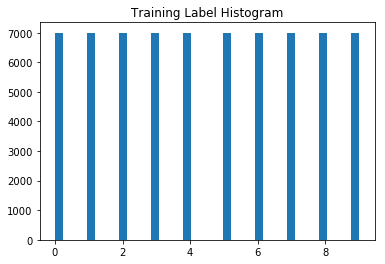

In [23]:
plt.hist(Y, bins='auto')
plt.title("Training Label Histogram")

__Each class has 7000 data points, when train and test are combined__

In [24]:
# this is small preprocessor function that find the class labels and replaces Certain percentage
# of each class with label 10
# I picked label 10 because it doesn't exist among the labels.
def remove_labels_randomly(Y,percntage):
    y_new = np.copy(Y)
    for i in range(0,10):
        # find the index of i's
        my_bin = list(np.where(Y == i))
        # calculate the percentage of data to be processed
        my_percentage = percntage
        num_iterations = int(len(my_bin[0])*my_percentage)
        # generate random numbers in range of my_bin and the size of num_iterations
        my_index = np.random.choice(range(len(my_bin[0])), num_iterations, replace=False)
        for j in range(0,num_iterations):
            new_index = my_bin[0][(my_index[j])]
            y_new[new_index] = 10
    return y_new

In [25]:
# Create new training label with 1% of labels left (99% removed randomly)
y_01 = remove_labels_randomly(Y,0.99)

In [26]:
y_01.shape

(70000,)

In [27]:
# 99% of labels are 10
remove_99_percent = list(np.where(y_01 == 10))
# 1% of the labels are from 0-9
leave_01_percent = list(np.where(y_01 != 10))

In [28]:
len(remove_99_percent[0])

69300

In [29]:
# 99% of the labels in the original labels are saved for future
y_99 = np.delete(Y, leave_01_percent)
# 1% of the labels
y_01 = np.delete(y_01, remove_99_percent)

In [30]:
y_01.shape

(700,)

In [31]:
# 1% of the feature set
x_01 = np.delete(X, remove_99_percent,0)
# 99% of the feature set
x_99 = np.delete(X, leave_01_percent,0)

In [32]:
x_01.shape

(700, 28, 28)

In [33]:
x_99.shape

(69300, 28, 28)

In [34]:
x_01 = x_01.reshape([-1, 28, 28, 1])

In [35]:
# use 1% of the data for building a model
# Split the data into Train, Test, and Validation 
X_train, X_test, y_train, y_test = train_test_split(x_01, y_01, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [36]:
X_train = np.divide(X_train,255)
X_test = np.divide(X_test,255)
X_val = np.divide(X_val,255)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 448
number of test examples = 140
number of validation examples = 112
X_train shape: (448, 28, 28, 1)
Y_train shape: (448, 10)
X_test shape: (140, 28, 28, 1)
Y_test shape: (140, 10)
X_val shape: (112, 28, 28, 1)
Y_val shape: (112, 10)


In [37]:
# create a new model for 5% labeled data
model_01 = Sequential()
model_01.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1)))
model_01.add(Activation('relu'))
model_01.add(MaxPooling2D(pool_size=(2, 2)))
model_01.add(Dropout(0.25))

model_01.add(Conv2D(32, (3, 3)))
model_01.add(Activation('relu'))
model_01.add(MaxPooling2D(pool_size=(2, 2)))
model_01.add(Dropout(0.25))

model_01.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_01.add(Dense(128, activation='relu'))
model_01.add(Dropout(0.5))
model_01.add(Dense(10, activation='softmax')) # 10 classes

In [38]:
model_01.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
activation_4 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
__________

In [39]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-03, decay=0.0)
model_01.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [40]:
my_model_01 = model_01.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20,shuffle=True)

Train on 448 samples, validate on 112 samples
Epoch 1/20
448/448 [==============================] - 2s 4ms/step - loss: 2.2862 - acc: 0.1295 - val_loss: 2.2370 - val_acc: 0.3036
Epoch 2/20
448/448 [==============================] - 1s 2ms/step - loss: 2.2176 - acc: 0.1808 - val_loss: 2.1286 - val_acc: 0.4643
Epoch 3/20
448/448 [==============================] - 1s 2ms/step - loss: 2.0521 - acc: 0.2746 - val_loss: 1.8794 - val_acc: 0.5268
Epoch 4/20
448/448 [==============================] - 1s 2ms/step - loss: 1.8498 - acc: 0.3638 - val_loss: 1.5407 - val_acc: 0.5446
Epoch 5/20
448/448 [==============================] - 1s 2ms/step - loss: 1.6585 - acc: 0.4241 - val_loss: 1.3832 - val_acc: 0.5625
Epoch 6/20
448/448 [==============================] - 1s 2ms/step - loss: 1.5050 - acc: 0.4554 - val_loss: 1.2528 - val_acc: 0.5714
Epoch 7/20
448/448 [==============================] - 1s 2ms/step - loss: 1.4331 - acc: 0.4754 - val_loss: 1.1769 - val_acc: 0.5714
Epoch 8/20
448/448 [==========

In [41]:
test_loss, test_accuracy = model_01.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy Acquired:', test_accuracy)

Test accuracy Acquired: 0.692857142857


In [42]:
x_99_reshaped = x_99.reshape([-1, 28, 28, 1])

In [43]:
x_99_reshaped.shape

(69300, 28, 28, 1)

In [44]:
predictions_99 = model_01.predict_classes(x_99_reshaped)

In [45]:
print(classification_report(y_99, predictions_99))

             precision    recall  f1-score   support

          0       0.65      0.82      0.73      6930
          1       0.91      0.95      0.93      6930
          2       0.56      0.61      0.59      6930
          3       0.79      0.61      0.68      6930
          4       0.49      0.81      0.61      6930
          5       0.98      0.66      0.79      6930
          6       0.31      0.08      0.12      6930
          7       0.76      0.77      0.77      6930
          8       0.93      0.89      0.91      6930
          9       0.75      0.98      0.85      6930

avg / total       0.71      0.72      0.70     69300



In [46]:
avg_f1_score_01 = 0.70

### Now lets start building a new classifier with only 5% of the initial dataset

In [47]:
# reload the data
(x_train, y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [48]:
# Concatenate Train and Test set
X = np.concatenate((x_train, X_test),axis=0)
Y = np.concatenate((y_train, Y_test),axis=0)

In [49]:
# Create new training label with 5% of labels left (95% removed randomly)
y_05 = remove_labels_randomly(Y,0.95)

In [50]:
# 95% of labels are 10
remove_95_percent = list(np.where(y_05 == 10))
# 5% of the labels are from 0-9
leave_05_percent = list(np.where(y_05 != 10))

In [51]:
# 95% of the labels in the original labels are saved for future
y_95 = np.delete(Y, leave_05_percent)
# 5% of the labels
y_05 = np.delete(y_05, remove_95_percent)

In [52]:
# 5% of the feature set
x_05 = np.delete(X, remove_95_percent,0)
# 95% of the feature set
x_95 = np.delete(X, leave_05_percent,0)

In [53]:
x_05.shape

(3500, 28, 28)

In [54]:
x_95.shape

(66500, 28, 28)

In [55]:
x_05 = x_05.reshape([-1, 28, 28, 1])

In [56]:
# use 5% of the data for building a model
# Split the data into Train, Test, and Validation 
X_train, X_test, y_train, y_test = train_test_split(x_05, y_05, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [57]:
X_train = np.divide(X_train,255)
X_test = np.divide(X_test,255)
X_val = np.divide(X_val,255)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 2240
number of test examples = 700
number of validation examples = 560
X_train shape: (2240, 28, 28, 1)
Y_train shape: (2240, 10)
X_test shape: (700, 28, 28, 1)
Y_test shape: (700, 10)
X_val shape: (560, 28, 28, 1)
Y_val shape: (560, 10)


In [58]:
# create a new model for 5% labeled data
model_05 = Sequential()
model_05.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1)))
model_05.add(Activation('relu'))
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.25))

model_05.add(Conv2D(32, (3, 3)))
model_05.add(Activation('relu'))
model_05.add(MaxPooling2D(pool_size=(2, 2)))
model_05.add(Dropout(0.25))

model_05.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_05.add(Dense(128, activation='relu'))
model_05.add(Dropout(0.5))
model_05.add(Dense(10, activation='softmax')) # 10 classes

In [59]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-03, decay=0.0)
model_05.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [60]:
my_model_05 = model_05.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20,shuffle=True)

Train on 2240 samples, validate on 560 samples
Epoch 1/20
2240/2240 [==============================] - 5s 2ms/step - loss: 2.0435 - acc: 0.2616 - val_loss: 1.3654 - val_acc: 0.5054
Epoch 2/20
2240/2240 [==============================] - 4s 2ms/step - loss: 1.2786 - acc: 0.5357 - val_loss: 0.9022 - val_acc: 0.6964
Epoch 3/20
2240/2240 [==============================] - 4s 2ms/step - loss: 1.0106 - acc: 0.6357 - val_loss: 0.7924 - val_acc: 0.7125
Epoch 4/20
2240/2240 [==============================] - 4s 2ms/step - loss: 0.8621 - acc: 0.6888 - val_loss: 0.6885 - val_acc: 0.7482
Epoch 5/20
2240/2240 [==============================] - 4s 2ms/step - loss: 0.7915 - acc: 0.7161 - val_loss: 0.6621 - val_acc: 0.7518
Epoch 6/20
2240/2240 [==============================] - 4s 2ms/step - loss: 0.7450 - acc: 0.7313 - val_loss: 0.6545 - val_acc: 0.7589
Epoch 7/20
2240/2240 [==============================] - 4s 2ms/step - loss: 0.6858 - acc: 0.7455 - val_loss: 0.6216 - val_acc: 0.7750
Epoch 8/20
2240

In [61]:
test_loss, test_accuracy = model_05.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy Acquired:', test_accuracy)

Test accuracy Acquired: 0.802857142517


In [62]:
x_95_reshaped = x_95.reshape([-1, 28, 28, 1])

In [63]:
predictions_95 = model_05.predict_classes(x_95_reshaped)

In [64]:
print(classification_report(y_95, predictions_95))

             precision    recall  f1-score   support

          0       0.73      0.83      0.78      6650
          1       0.94      0.97      0.95      6650
          2       0.66      0.70      0.68      6650
          3       0.82      0.83      0.82      6650
          4       0.57      0.87      0.69      6650
          5       0.96      0.92      0.94      6650
          6       0.60      0.11      0.19      6650
          7       0.93      0.89      0.91      6650
          8       0.92      0.95      0.93      6650
          9       0.90      0.96      0.93      6650

avg / total       0.80      0.80      0.78     66500



In [108]:
avg_f1_score_05 = 0.78

### Now lets start building a new classifier with only 10% of the initial dataset

In [66]:
# reload the data
(x_train, y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [67]:
# Concatenate Train and Test set
X = np.concatenate((x_train, X_test),axis=0)
Y = np.concatenate((y_train, Y_test),axis=0)

In [68]:
y_10 = remove_labels_randomly(Y,0.90)

In [69]:
# 90% of labels are 10
remove_90_percent = list(np.where(y_10 == 10))
# 10% of the labels are from 0-9
leave_10_percent = list(np.where(y_10 != 10))

In [70]:
# 90% of the labels in the original labels are saved for future
y_90 = np.delete(Y, leave_10_percent)
# 10% of the labels
y_10 = np.delete(y_10, remove_90_percent)

In [71]:
# 10% of the feature set
x_10 = np.delete(X, remove_90_percent,0)
# 90% of the feature set
x_90 = np.delete(X, leave_10_percent,0)

In [72]:
x_10.shape

(7000, 28, 28)

In [73]:
x_90.shape

(63000, 28, 28)

In [74]:
x_10 = x_10.reshape([-1, 28, 28, 1])

In [75]:
# use 10% of the data for building a model
# Split the data into Train, Test, and Validation 
X_train, X_test, y_train, y_test = train_test_split(x_10, y_10, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [76]:
X_train = np.divide(X_train,255)
X_test = np.divide(X_test,255)
X_val = np.divide(X_val,255)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 4480
number of test examples = 1400
number of validation examples = 1120
X_train shape: (4480, 28, 28, 1)
Y_train shape: (4480, 10)
X_test shape: (1400, 28, 28, 1)
Y_test shape: (1400, 10)
X_val shape: (1120, 28, 28, 1)
Y_val shape: (1120, 10)


In [77]:
# create a new model for 10% labeled data
model_10 = Sequential()
model_10.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1)))
model_10.add(Activation('relu'))
model_10.add(MaxPooling2D(pool_size=(2, 2)))
model_10.add(Dropout(0.25))

model_10.add(Conv2D(32, (3, 3)))
model_10.add(Activation('relu'))
model_10.add(MaxPooling2D(pool_size=(2, 2)))
model_10.add(Dropout(0.25))

model_10.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_10.add(Dense(128, activation='relu'))
model_10.add(Dropout(0.5))
model_10.add(Dense(10, activation='softmax')) # 10 classes

In [78]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-03, decay=0.0)
model_10.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [79]:
my_model_10 = model_10.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20,shuffle=True)

Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 10s 2ms/step - loss: 1.7283 - acc: 0.3482 - val_loss: 0.9867 - val_acc: 0.6813
Epoch 2/20
4480/4480 [==============================] - 9s 2ms/step - loss: 0.9966 - acc: 0.6368 - val_loss: 0.7184 - val_acc: 0.7375
Epoch 3/20
4480/4480 [==============================] - 9s 2ms/step - loss: 0.7868 - acc: 0.7121 - val_loss: 0.6108 - val_acc: 0.7705
Epoch 4/20
4480/4480 [==============================] - 9s 2ms/step - loss: 0.7006 - acc: 0.7411 - val_loss: 0.5626 - val_acc: 0.7911
Epoch 5/20
4480/4480 [==============================] - 9s 2ms/step - loss: 0.6510 - acc: 0.7549 - val_loss: 0.5238 - val_acc: 0.7946
Epoch 6/20
4480/4480 [==============================] - 9s 2ms/step - loss: 0.6047 - acc: 0.7734 - val_loss: 0.4996 - val_acc: 0.8018
Epoch 7/20
4480/4480 [==============================] - 9s 2ms/step - loss: 0.5720 - acc: 0.7848 - val_loss: 0.5000 - val_acc: 0.8152
Epoch 8/20
44

In [80]:
test_loss, test_accuracy = model_10.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy Acquired:', test_accuracy)

Test accuracy Acquired: 0.859285713945


In [81]:
x_90_reshaped = x_90.reshape([-1, 28, 28, 1])

In [82]:
predictions_90 = model_10.predict_classes(x_90_reshaped)

In [83]:
print(classification_report(y_90, predictions_90))

             precision    recall  f1-score   support

          0       0.80      0.81      0.81      6300
          1       0.98      0.97      0.98      6300
          2       0.74      0.80      0.77      6300
          3       0.86      0.88      0.87      6300
          4       0.72      0.77      0.74      6300
          5       0.94      0.96      0.95      6300
          6       0.66      0.54      0.60      6300
          7       0.95      0.89      0.92      6300
          8       0.96      0.96      0.96      6300
          9       0.93      0.96      0.94      6300

avg / total       0.85      0.85      0.85     63000



In [109]:
avg_f1_score_10 = 0.85

### Now lets start building a new classifier with only 20% of the initial dataset

In [85]:
# reload the data
(x_train, y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Concatenate Train and Test set
X = np.concatenate((x_train, X_test),axis=0)
Y = np.concatenate((y_train, Y_test),axis=0)

In [86]:
# Create new training label with 20% of labels left (80% removed randomly)
y_20 = np.copy(Y)

In [87]:
y_20 = remove_labels_randomly(Y,0.80)

In [88]:
# 80% of labels are 10
remove_80_percent = list(np.where(y_20 == 10))
# 20% of the labels are from 0-9
leave_20_percent = list(np.where(y_20 != 10))

# 80% of the labels in the original labels are saved for future
y_80 = np.delete(Y, leave_20_percent)
# 10% of the labels
y_20 = np.delete(y_20, remove_80_percent)

# 20% of the feature set
x_20 = np.delete(X, remove_80_percent,0)
# 80% of the feature set
x_80 = np.delete(X, leave_20_percent,0)

In [89]:
x_20 = x_20.reshape([-1, 28, 28, 1])

In [90]:
# use 20% of the data for building a model
# Split the data into Train, Test, and Validation 
X_train, X_test, y_train, y_test = train_test_split(x_20, y_20, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [91]:
X_train = np.divide(X_train,255)
X_test = np.divide(X_test,255)
X_val = np.divide(X_val,255)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_val = to_categorical(y_val)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

number of training examples = 8960
number of test examples = 2800
number of validation examples = 2240
X_train shape: (8960, 28, 28, 1)
Y_train shape: (8960, 10)
X_test shape: (2800, 28, 28, 1)
Y_test shape: (2800, 10)
X_val shape: (2240, 28, 28, 1)
Y_val shape: (2240, 10)


In [92]:
# create a new model for 20% labeled data
model_20 = Sequential()
model_20.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1)))
model_20.add(Activation('relu'))
model_20.add(MaxPooling2D(pool_size=(2, 2)))
model_20.add(Dropout(0.25))

model_20.add(Conv2D(32, (3, 3)))
model_20.add(Activation('relu'))
model_20.add(MaxPooling2D(pool_size=(2, 2)))
model_20.add(Dropout(0.25))

model_20.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_20.add(Dense(128, activation='relu'))
model_20.add(Dropout(0.5))
model_20.add(Dense(10, activation='softmax')) # 10 classes

In [93]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-03, decay=0.0)
model_20.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [94]:
my_model_20 = model_20.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20,shuffle=True)

Train on 8960 samples, validate on 2240 samples
Epoch 1/20
8960/8960 [==============================] - 18s 2ms/step - loss: 1.3163 - acc: 0.5202 - val_loss: 0.7132 - val_acc: 0.7446
Epoch 2/20
8960/8960 [==============================] - 17s 2ms/step - loss: 0.7289 - acc: 0.7277 - val_loss: 0.6010 - val_acc: 0.7719
Epoch 3/20
8960/8960 [==============================] - 17s 2ms/step - loss: 0.6366 - acc: 0.7680 - val_loss: 0.5403 - val_acc: 0.7978
Epoch 4/20
8960/8960 [==============================] - 17s 2ms/step - loss: 0.5773 - acc: 0.7821 - val_loss: 0.5115 - val_acc: 0.7987
Epoch 5/20
8960/8960 [==============================] - 17s 2ms/step - loss: 0.5422 - acc: 0.7925 - val_loss: 0.4847 - val_acc: 0.8129
Epoch 6/20
8960/8960 [==============================] - 17s 2ms/step - loss: 0.5059 - acc: 0.8055 - val_loss: 0.4733 - val_acc: 0.8107
Epoch 7/20
8960/8960 [==============================] - 17s 2ms/step - loss: 0.4791 - acc: 0.8232 - val_loss: 0.4387 - val_acc: 0.8299
Epoch 8

In [95]:
test_loss, test_accuracy = model_20.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy Acquired:', test_accuracy)

Test accuracy Acquired: 0.8775


In [96]:
x_80_reshaped = x_80.reshape([-1, 28, 28, 1])

In [97]:
x_80_reshaped.shape

(56000, 28, 28, 1)

In [98]:
predictions_80 = model_20.predict_classes(x_80_reshaped)

In [99]:
print(classification_report(y_80, predictions_80))

             precision    recall  f1-score   support

          0       0.88      0.72      0.80      5600
          1       0.99      0.97      0.98      5600
          2       0.87      0.67      0.76      5600
          3       0.90      0.88      0.89      5600
          4       0.60      0.94      0.73      5600
          5       0.94      0.98      0.96      5600
          6       0.63      0.52      0.57      5600
          7       0.97      0.88      0.92      5600
          8       0.91      0.98      0.94      5600
          9       0.93      0.97      0.95      5600

avg / total       0.86      0.85      0.85     56000



In [110]:
avg_f1_score_20 = 0.85

In [111]:
f1_score_list = [avg_f1_score_01,avg_f1_score_05,avg_f1_score_10,avg_f1_score_20,avg_f1_score_100]

In [112]:
f1_score_list

[0.71, 0.78, 0.85, 0.85, 0.9]

In [113]:
data_percentages = [1,5,10,20,100]

In [114]:
def funcLog(x, a, b):
    return a+b*np.log(x)

In [115]:
popt, pcov = curve_fit(funcLog, data_percentages, f1_score_list, p0=(-1, 1))
x_new = np.linspace(data_percentages[0], data_percentages[-1], 50)
y_new = funcLog(x_new, *popt)

In [116]:
popt

array([ 0.72123289,  0.04202542])

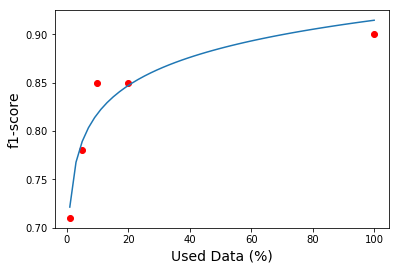

In [117]:
plt.plot(data_percentages, f1_score_list, 'ro', x_new,y_new)
plt.ylabel('f1-score', fontsize=14)
plt.xlabel('Used Data (%)', fontsize=14)